In [ ]:
import torch
import torchvision
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive #для Colab
drive.mount('/content/gdrive/') #для Colab

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip #для Colab

In [ ]:
!ls -1 #для Colab

characters_illustration.png

gdrive

sample_data

sample_submission.csv

testset

train


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 27 08:55:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

True

In [ ]:
import pickle
import numpy as np
from skimage import io

import PIL
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")
print(DEVICE)

cuda


In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        #параметр для аугментации данных

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для аугментации тренировочных изображений, преобразования изображений в тензоры PyTorch и нормализации входа
        standart_transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            # добавление аугментации
            augmentations_transform = transforms.Compose([
              transforms.RandomRotation(degrees=(-25, 25)),
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
              transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
              standart_transform
          ])
            x = augmentations_transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        elif self.mode == 'test':
            x = standart_transform(x)
            return x
        else:
            x = standart_transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from pathlib import Path
#DATA_DIR = Path("/kaggle/input/journey-to-springfield/") #для Kaggle
#TRAIN_DIR = DATA_DIR / 'train/simpsons_dataset' #для Kaggle
#TEST_DIR = DATA_DIR / 'testset/testset' #для Kaggle
TRAIN_DIR = Path('train/simpsons_dataset') # для Colab
TEST_DIR = Path('testset/testset') # для Colab
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991
ls: cannot access '/kaggle/input/journey-springfield/train/simpsons_dataset': No such file or directory


In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode="test")
val_dataset = SimpsonsDataset(val_files, mode='val')

Посмотрим на датасет

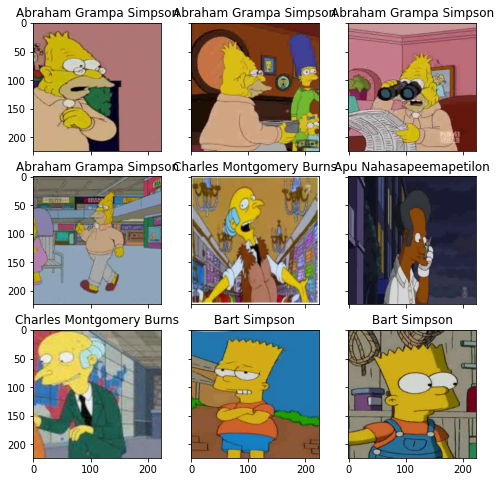

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

15699


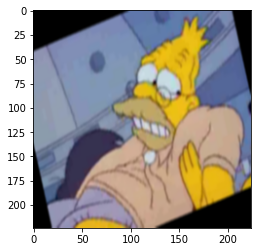

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')

img, label = train_dataset[0]
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
name = label_encoder.inverse_transform(np.array([label]))[0]

imshow(img)
name
print(len(train_dataset))

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c6c667df30546e92bbef8291b6f7f6951825582d39471546547e04c0ca59808d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet_pytorch


In [ ]:
n_classes = len(np.unique(train_val_labels))
model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=n_classes)
model._blocks[0]
model._fc

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


Linear(in_features=1408, out_features=42, bias=True)

In [ ]:
unfreezed_blocks = 4
for param in model._blocks[:-unfreezed_blocks]:
    param.requires_grad = False

In [ ]:
model.to(DEVICE)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step() #добавлен scheduler
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        optimizer = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler) #учитывается scheduler
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=12, batch_size=64)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 0.6096173179051673


epoch:   8%|▊         | 1/12 [12:39<2:19:10, 759.14s/it]


Epoch 001 train_loss: 0.6096     val_loss 0.2793 train_acc 0.8522 val_acc 0.9264
loss 0.3342844269392832


epoch:  17%|█▋        | 2/12 [23:28<1:55:44, 694.44s/it]


Epoch 002 train_loss: 0.3343     val_loss 0.2421 train_acc 0.9145 val_acc 0.9429
loss 0.17825958028808733


epoch:  25%|██▌       | 3/12 [34:11<1:40:40, 671.16s/it]


Epoch 003 train_loss: 0.1783     val_loss 0.4298 train_acc 0.9530 val_acc 0.8852
loss 0.15738260857263775


epoch:  33%|███▎      | 4/12 [44:54<1:27:58, 659.81s/it]


Epoch 004 train_loss: 0.1574     val_loss 0.1521 train_acc 0.9582 val_acc 0.9641
loss 0.11049173974842393


epoch:  42%|████▏     | 5/12 [55:39<1:16:21, 654.55s/it]


Epoch 005 train_loss: 0.1105     val_loss 0.1538 train_acc 0.9711 val_acc 0.9675
loss 0.13981542794164367


epoch:  50%|█████     | 6/12 [1:06:19<1:04:58, 649.78s/it]


Epoch 006 train_loss: 0.1398     val_loss 0.1740 train_acc 0.9617 val_acc 0.9610
loss 0.10580159067579387


epoch:  58%|█████▊    | 7/12 [1:17:00<53:53, 646.76s/it]  


Epoch 007 train_loss: 0.1058     val_loss 0.1778 train_acc 0.9722 val_acc 0.9656
loss 0.034075495568060485


epoch:  67%|██████▋   | 8/12 [1:27:38<42:55, 643.92s/it]


Epoch 008 train_loss: 0.0341     val_loss 0.1020 train_acc 0.9910 val_acc 0.9815
loss 0.018036094848029788


epoch:  75%|███████▌  | 9/12 [1:38:13<32:03, 641.08s/it]


Epoch 009 train_loss: 0.0180     val_loss 0.1013 train_acc 0.9953 val_acc 0.9820
loss 0.015270489606683828


epoch:  83%|████████▎ | 10/12 [1:48:50<21:19, 639.86s/it]


Epoch 010 train_loss: 0.0153     val_loss 0.1029 train_acc 0.9968 val_acc 0.9818
loss 0.00897864808813799


epoch:  92%|█████████▏| 11/12 [1:59:27<10:38, 639.00s/it]


Epoch 011 train_loss: 0.0090     val_loss 0.1062 train_acc 0.9977 val_acc 0.9822
loss 0.009068441553670157


epoch: 100%|██████████| 12/12 [2:10:06<00:00, 650.53s/it]


Epoch 012 train_loss: 0.0091     val_loss 0.1158 train_acc 0.9974 val_acc 0.9836


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

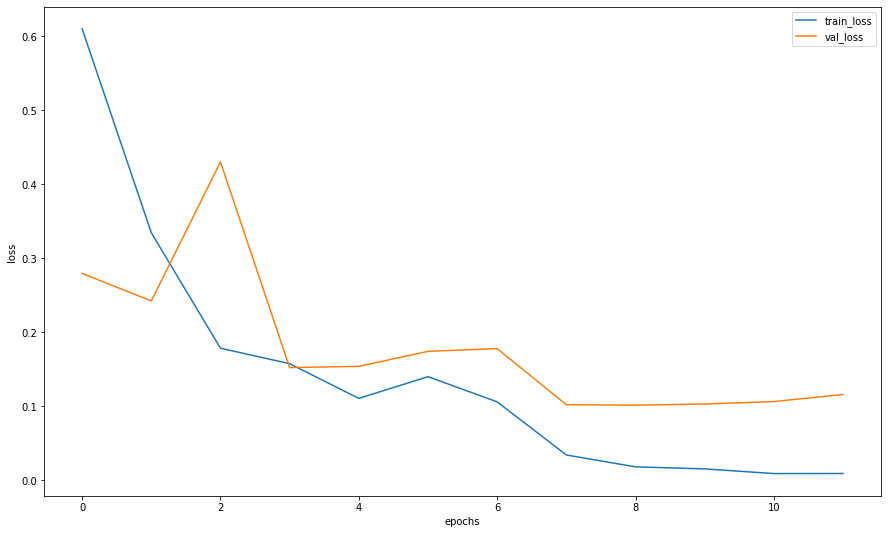

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
from sklearn.metrics import f1_score
def get_f1_of_validation(model):

    imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]
    probs_ims = predict(model, imgs)        # predict - нам написанная функция (она софтмакс к выходам применяет)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
    y_pred = np.argmax(probs_ims, -1)

    actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]
    preds_class = [label_encoder.classes_[i] for i in y_pred]

    return f1_score(actual_labels, y_pred, average='micro')

In [ ]:
get_f1_of_validation(model)

0.9835689721054642

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
#my_submit.to_csv('./My_model_to_predict.csv', index=False) #для Kaggle
my_submit.to_csv('gdrive/MyDrive/Simpsons/My_model_to_predict.csv', index=False) #для googleColab

0.99574 на Kaggle